In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# k-Armed Bandit Problem

The k-armed bandit problem involves repeatedly choosing among k options (actions), each action produces a reward that is sampled from a stationary probability distribution. The objective is to maximize total reward over a large number of time steps. For this notebook, we will use $k=10$.

Imagine a box with 10 levers, and at each time step you get to pick which lever to pull. Stationary distribution means that the reward distribution for each lever is fixed at creation, and does not change over time. 

## $\epsilon$-Greedy Action Selection Method
One way of selecting the best lever to pull is to look at the past levers that have been pulled, and take the one that has the highest estimate for future reward. 
$$ A_t = argmax_a Q_t(a) $$
- ties amongst actions are broken arbitrarily

Here is how you form the estimate
$$ 
    Q_t(a) = = \frac{\sum_{i=1}^{t-1}R_i\mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}}
$$

  = sum of rewards with $a$ taken prior to $t$ / #times $a$ has been taken prior to $t$

## The 10-armed bandit testbed
The 10-armed bandit testbed is a set of 2000 10-armed bandit problem. Each bandit represents a reward function for selection action `i`, where `i=1,...,10`. Each problem has 10 bandits, which means that there are 10 such reward functions per problem definition. The way that we store this is through a 2000x10 numpy array, each entry drawn from a N(0,1). Each row represents a problem, and there are 2000 such problems.

In [2]:
testbed = np.random.normal(0, 1, (2000, 10))

In [3]:
testbed

array([[ 1.17710374, -0.45182162,  0.56116416, ..., -0.80652915,
         1.07636233, -0.02133469],
       [-0.48074952, -0.17135982, -0.99393329, ..., -0.09791191,
        -0.30821296, -0.35966528],
       [-0.48428776,  0.00269813,  0.06806088, ..., -0.21529206,
        -0.57736596, -1.12369157],
       ...,
       [-0.3537136 ,  0.71161166,  0.89716704, ..., -1.97722903,
        -0.37495783, -0.6067886 ],
       [-1.09115292, -0.91533413, -0.02706017, ..., -1.10827954,
         0.21144078,  0.11094678],
       [ 0.57773191, -1.09443121, -1.81649957, ...,  0.83195547,
         1.35498231, -0.59861933]])

# Creating a $\epsilon$-Greedy Bandit Agent

The algorithm to update the value estimates is a simple incremental update that take O(1) space and O(1) time per timestep.

In [4]:
class BanditAgent:
    def __init__(self, eps=0, num_bandits=10):
        self._eps=eps
        self._num_bandits=num_bandits
        self._estimates=np.zeros(num_bandits)
        self._frequencies=np.zeros(num_bandits)
        self._total_reward=0

    def select_action(self):
        roll = np.random.uniform()
        if (roll < self._eps):
            # non-greedy case
            return np.random.randint(0, self._num_bandits)
        else:
            return np.argmax(self._estimates)

    def update_estimate(self, action, reward):
        # N(A) = N(A) + 1
        self._frequencies[action]+=1
        # Q(A) = Q(A) + (1/N(A)) * (R - Q(A))
        self._estimates[action] = self._estimates[action] + (1/self._frequencies[action])*(reward - self._estimates[action])
        self._total_reward += reward


In [5]:
def run_testbed(epsilon):
    rewards = np.zeros((2000,1000))
    actions = np.zeros((2000,1000))
    
    for problem in range(2000):
        bandit = BanditAgent(epsilon)
        optimal_action = np.argmax(testbed[problem])
        
        for time in range(1000):
            action = bandit.select_action()
            reward = np.random.normal(testbed[problem][action])
            bandit.update_estimate(action, reward)
            
            rewards[problem][time] = reward
            actions[problem][time] = (action == optimal_action)
    
    average_reward = rewards.mean(axis=0)
    average_optimal = actions.mean(axis=0)
    return average_reward, average_optimal
    

In [6]:
%%time
data = pd.DataFrame(columns=["Average Reward", "% Optimal"], index=pd.Index(data=[0,0.01,0.1], name="Epsilon"))
for eps in data.index:
    average_reward, percent_optimal = run_testbed(eps)
    data.loc[eps] = [average_reward, percent_optimal]

CPU times: user 20 s, sys: 9.46 ms, total: 20 s
Wall time: 20 s


In [7]:
data

,Average Reward,% Optimal
Epsilon,,
0.00,"[-0.08678103122932343, 0.3073162363819472, 0.3...","[0.097, 0.1455, 0.176, 0.2025, 0.224, 0.242, 0..."
0.01,"[-0.04148517139370882, 0.2786750821938171, 0.4...","[0.097, 0.149, 0.1785, 0.2035, 0.223, 0.242, 0..."
0.10,"[-0.05126139531437423, 0.2608196577687293, 0.4...","[0.0945, 0.1435, 0.1675, 0.1885, 0.2135, 0.226..."


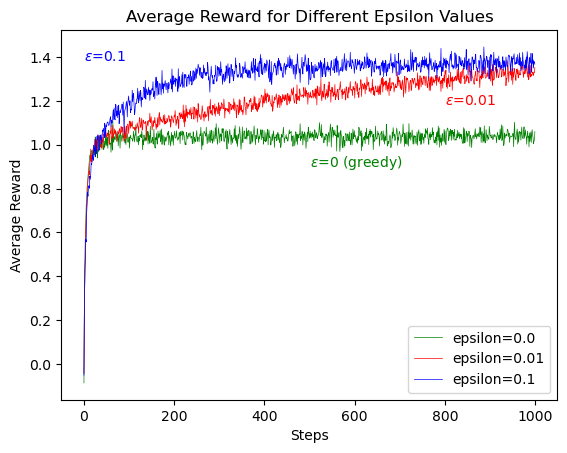

In [8]:
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']

# Plot average reward for each epsilon
for idx, color in zip(data.index, colors):
    plt.plot(data.loc[idx]['Average Reward'], label=f'epsilon={idx}', color=color, linewidth=0.5)
    
plt.text(0, 1.4, f'$\epsilon$={0.1}', 
         color='blue', fontsize=10, verticalalignment='center')

plt.text(800, 1.2, f'$\epsilon$={0.01}', 
         color='red', fontsize=10, verticalalignment='center')

plt.text(500, 0.92, f'$\epsilon$={0} (greedy)', 
         color='green', fontsize=10, verticalalignment='center')


# Add labels and title
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title('Average Reward for Different Epsilon Values')
plt.legend()

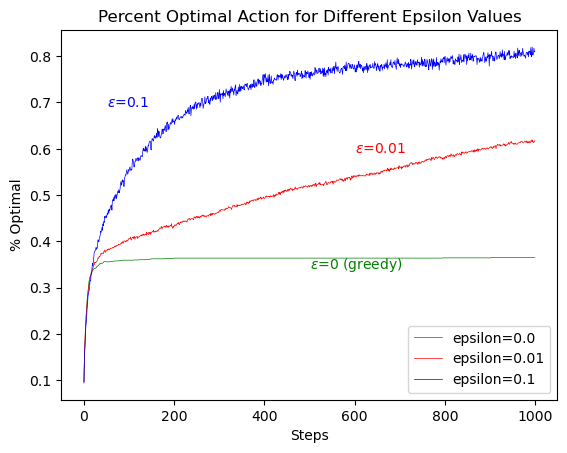

In [9]:
# Define colors for each epsilon value
colors = ['green', 'red', 'blue']

# Plot average reward for each epsilon
for idx, color in zip(data.index, colors):
    plt.plot(data.loc[idx]['% Optimal'], label=f'epsilon={idx}', color=color, linewidth=0.5)
    
plt.text(50, 0.7, f'$\epsilon$={0.1}', 
         color='blue', fontsize=10, verticalalignment='center')

plt.text(600, 0.6, f'$\epsilon$={0.01}', 
         color='red', fontsize=10, verticalalignment='center')

plt.text(500, 0.35, f'$\epsilon$={0} (greedy)', 
         color='green', fontsize=10, verticalalignment='center')


# Add labels and title
plt.xlabel('Steps')
plt.ylabel('% Optimal')
plt.title('Percent Optimal Action for Different Epsilon Values')
plt.legend()